# Tutorial 1

In this notebook we will try to simply augment the size of given training sets. Using the pre-defined functions of pyraug.

## Example 1: MNIST

### Get the data

#### Import modules

In [45]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


False

#### Extract the data
We only selected 200 samples and display some of the training samples

In [46]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=None)

In [32]:
cifar_trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=None)

Files already downloaded and verified


In [33]:
n_samples = 200
dataset_to_augment = cifar_trainset.data[np.array(cifar_trainset.targets)==2][:n_samples] 
dataset_to_augment.shape

(200, 32, 32, 3)

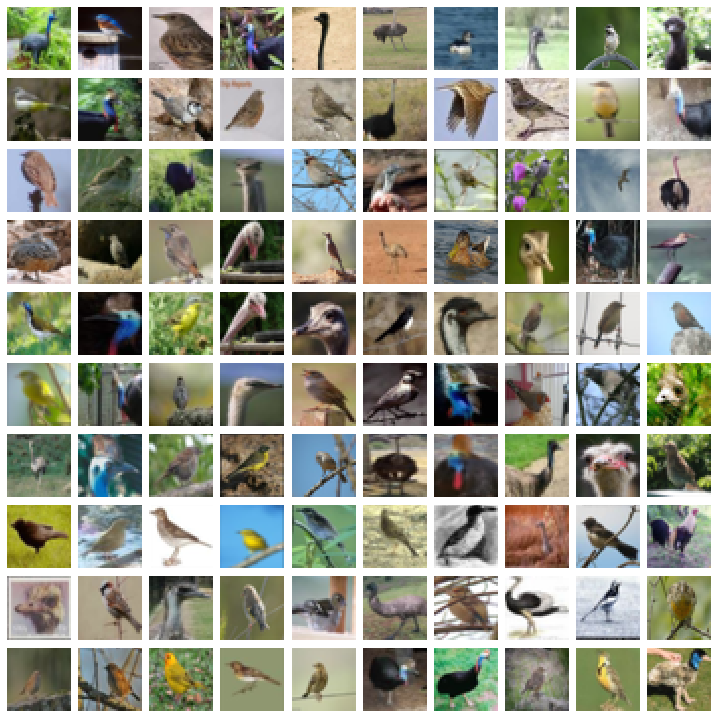

In [34]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
        for j in range(10):
                axes[i][j].matshow(dataset_to_augment[i*10 +j].reshape(32, 32, 3), cmap='gray')
                axes[i][j].axis('off')

plt.tight_layout(pad=0.8)
#plt.savefig('plots/training_data_3_rotated_corrupted.pdf')

### Let's augment them !

The only thing you have to do is import the function `augment_data` from pyraug, populate it with your data and provided the number of samples yout want to generate. This will call a RHVAE model, train it on your data and generate the requested number of samples.
Let's do it!

In [35]:
from pyraug.trainers.training_config import TrainingConfig
from pyraug.data import *

In [7]:
training_config = TrainingConfig(
    output_dir='my_model',
    no_cuda=True,
    learning_rate=1e-3,
    batch_size=200,
    max_epochs=2000)

In [36]:
from pyraug.pipelines.training import TrainingPipeline
from pyraug.models import RHVAE
from pyraug.models.rhvae import RHVAEConfig
import torch

In [9]:
from pyraug.models.nn import BaseEncoder, BaseDecoder
import torch.nn as nn

class Encoder_Conv(BaseEncoder):
    def __init__(self, args):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.n_channels = 3

        self.layers = nn.Sequential(
            nn.Conv2d(
                self.n_channels, out_channels=32, kernel_size=3, stride=2, padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.fc1 = nn.Sequential(nn.Linear(512, 400), nn.ReLU())

        self.mu = nn.Linear(400, self.latent_dim)
        self.std = nn.Linear(400, self.latent_dim)

    def forward(self, x):
        out = self.layers(
            x.reshape(
                -1, self.n_channels, 32, 32
                )
            )
        out = self.fc1(out.reshape(x.shape[0], -1))
        return self.mu(out), self.std(out)


class Decoder_Conv(BaseDecoder):
    def __init__(self, args):
        BaseDecoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.n_channels = 3

        self.fc1 = nn.Sequential(
            nn.Linear(self.latent_dim, 400), nn.ReLU(), nn.Linear(400, 512), nn.ReLU()
        )

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(
                32,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=0,
                output_padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32,
                out_channels=self.n_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(self.n_channels),
            nn.Sigmoid(),
        )

    def forward(self, z):
        out = self.fc1(z)
        out = self.layers(out.reshape(z.shape[0], 32, 4, 4))
        return out.reshape(z.shape[0], -1)

In [37]:
dataset_to_augment = np.transpose(dataset_to_augment, (0, 3, 2, 1))

In [38]:
dataset_to_augment.shape

(200, 3, 32, 32)

In [39]:
model_config = RHVAEConfig(input_dim=32*32*3)

#encoder = Encoder_Conv(model_config)
#decoder = Decoder_Conv(model_config)

In [13]:
mu, _ = encoder(torch.tensor(dataset_to_augment).type(torch.float))

In [14]:
decoder(mu).shape

torch.Size([200, 3072])

In [43]:
model = RHVAE(
    model_config=model_config)

In [44]:
torch.manual_seed(8)
pipeline = TrainingPipeline(
    data_loader=None,
    data_processor=None,
    model=model,
    optimizer=None,
    training_config=None)
pipeline(train_data=dataset_to_augment, log_output_dir='output_logs')

Created dummy_output_dir folder since did not exist.
Created dummy_output_dir folder since did not exist.
Model passed sanity check !

Model passed sanity check !

Created dummy_output_dir/training_2021-06-22_17-49-01. 
Training config, checkpoints and final model will be saved here.

Created dummy_output_dir/training_2021-06-22_17-49-01. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !
Successfully launched training !


KeyboardInterrupt: 

In [108]:
from pyraug.pipelines.generation import GenerationPipeline
from pyraug.models.rhvae import RHVAESamplerConfig
from pyraug.models.rhvae.rhvae_sampler import RHVAESampler

In [127]:
training_folders = sorted(os.listdir('my_model'))
last_training = training_folders[-1]

In [128]:
last_training

'training_2021-06-15_11-54-32'

In [109]:
model = RHVAE.load_from_folder(os.path.join())
model.centroids_tens.shape

torch.Size([200, 10])

In [110]:
RHVAESamplerConfig(np)

RHVAESamplerConfig(output_dir=None, batch_size=50, samples_per_save=500, no_cuda=False, mcmc_steps_nbr=100, n_lf=15, eps_lf=0.03, beta_zero=1.0)

In [145]:
sampler = RHVAESampler(model=model, sampler_config=RHVAESamplerConfig(mcmc_steps_nbr=10, batch_size=100, no_cuda=True))

In [146]:
generation_pipe = GenerationPipeline(
    model=model,
    sampler=sampler
)

In [147]:
generation_pipe(100)

tensor([ 72, 190,  23, 191,  84,  35, 149,  68, 184,  18,   4, 184, 122, 151,
         10, 192,  89,  70, 112, 174, 142, 109,  17, 127,  58, 165,  24, 122,
         30, 169,  15,  28,   1, 170, 134, 196,  54,  15, 146, 157, 177,  35,
         26, 168, 196,  95,  88,  34, 186, 184, 140, 143,  46,  12,  43, 192,
         35, 156,  63, 156, 147,  72,  22,  41,  86,  61,   2, 123,  34,   2,
        143,  62,  77,  40,  75, 103, 178, 132,   0, 129, 190,  47, 125, 159,
        159, 108, 193,  49,  18, 145,  54,  68,  42,  58,  88,  76, 174, 186,
        191, 172])
tensor([[ 6.2064e-01, -1.8678e+00, -2.2741e-01,  2.1884e+00, -1.2394e+00,
         -1.7448e+00,  2.8581e+00, -1.0126e+00,  1.3242e+00, -1.6315e+00],
        [ 4.5489e-01, -2.3493e+00, -8.3718e-01,  2.1942e+00, -4.9545e-01,
         -1.0538e+00,  1.4548e+00, -1.4818e+00,  1.4507e+00, -1.0028e+00],
        [ 3.7232e-01, -1.8319e+00, -2.1234e-01,  1.4869e+00, -9.8034e-01,
         -1.1417e+00,  2.1828e+00, -1.0483e+00,  1.2311e+00, -1

In [25]:
generated_data = torch.load('../scripts/outputs/my_generated_data_from_script/generation_2021-06-15_16-06-55/generated_data_50_0.pt')

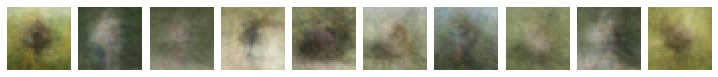

In [27]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
im_n = 0
for i in range(10):
        
                axes[i].matshow(generated_data[i].cpu().reshape(32, 32, 3), cmap='gray')
                axes[i].axis('off')

plt.tight_layout(pad=0.8)

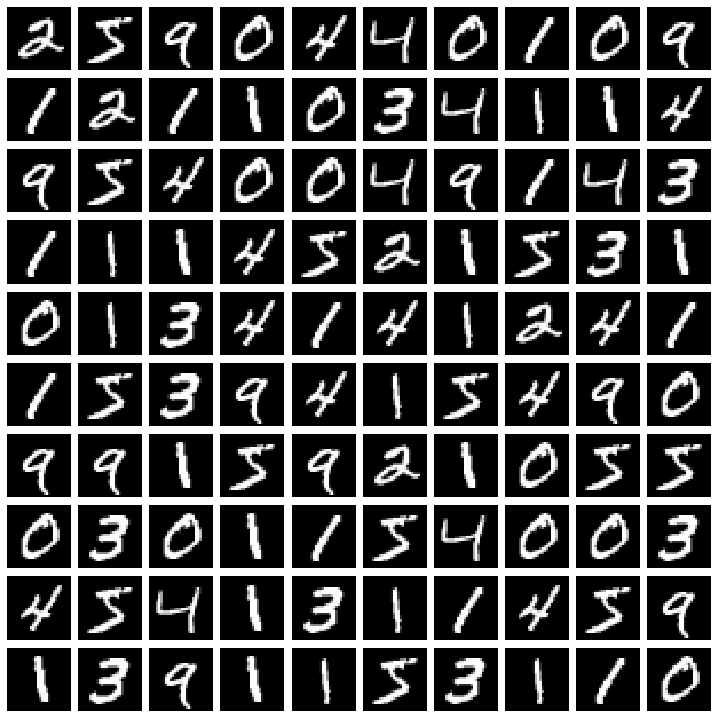

In [120]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
im_n = 0
for i in range(10):
        for j in range(10):
                axes[i][j].matshow(pipeline.trainer.train_loader.dataset.data[10*i+j].cpu().reshape(28, 28), cmap='gray')
                axes[i][j].axis('off')

plt.tight_layout(pad=0.8)

In [8]:
from pyraug.models.rhvae.rhvae_sampler import RHVAESampler, RHVAESamplerConfig

In [9]:
sampler = RHVAESampler(model, RHVAESamplerConfig())

tensor([[-0.5985,  1.1016,  1.5223,  ...,  1.3661, -3.3497, -2.3714],
        [-1.7094,  0.9256, -0.8169,  ..., -0.3815, -0.6951, -2.3005],
        [-1.7986,  1.1095,  0.0925,  ...,  1.4927, -1.7740, -2.2956],
        ...,
        [ 0.3662,  1.6328, -0.7616,  ..., -1.2705, -3.9515, -1.3101],
        [-0.7977,  1.3706, -0.9864,  ..., -0.1350, -2.6551, -1.6866],
        [-0.3779,  0.6218,  0.6110,  ...,  2.7358, -2.6942, -1.7261]],
       device='cuda:0')
tensor([[[ 6.4326e-01,  1.2422e-02,  2.9660e-02,  ...,  2.2557e-02,
          -2.0099e-03,  6.1290e-02],
         [ 1.2422e-02,  6.5083e-01, -1.5031e-02,  ..., -1.6493e-02,
           3.1493e-02, -2.9597e-02],
         [ 2.9660e-02, -1.5031e-02,  5.6491e-01,  ..., -2.1869e-02,
          -2.2422e-02, -2.2353e-02],
         ...,
         [ 2.2557e-02, -1.6493e-02, -2.1869e-02,  ...,  6.3957e-01,
          -4.6333e-02,  3.0891e-02],
         [-2.0099e-03,  3.1493e-02, -2.2422e-02,  ..., -4.6333e-02,
           7.1043e-01, -1.8424e-02],
   

In [173]:
RHVAEConfig.from_json_file('../scripts/configs/rhvae_config.json')

RHVAEConfig(input_dim=None, latent_dim=10, uses_default_encoder=True, uses_default_decoder=True, n_lf=3, eps_lf=0.001, beta_zero=0.3, temperature=1.5, regularization=0.01, uses_default_metric=True)

In [174]:
TrainingConfig.from_json_file('../scripts/configs/training_config.json')

TrainingConfig(output_dir=None, batch_size=50, max_epochs=200, learning_rate=0.001, train_early_stopping=50, eval_early_stopping=None, steps_saving=1000, seed=8, no_cuda=False, verbose=True)

In [176]:
RHVAESamplerConfig.from_json_file('../scripts/configs/rhvae_sampler_config.json')

RHVAESamplerConfig(output_dir='my_generated_data', batch_size=50, samples_per_save=500, no_cuda=False, mcmc_steps_nbr=100, n_lf=15, eps_lf=0.03, beta_zero=1.0)

In [10]:
sampler.sample(2)

In [116]:
for i in range(30, 200):
    for j in range(i+1, 200):
        assert not torch.equal(model.centroids_tens[i], model.centroids_tens[j]), (i, j)

AssertionError: (30, 31)

In [16]:
model.G_inv(torch.randn(10, 10).cuda())

RuntimeError: ignored

In [14]:
sampler.m

Parameter containing:
tensor([1.5000], device='cuda:0')

RuntimeError: ignored

Let's have a look to the generated samples

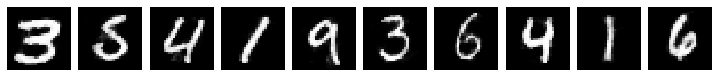

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
im_n = 20
for i in range(10):
        axes[i].matshow(generated_data[im_n+i].cpu().reshape(28, 28), cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.8)

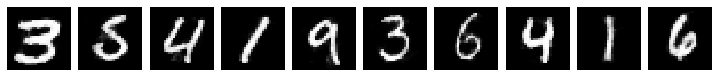

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
im_n = 20
for i in range(10):
        axes[i].matshow(generated_data[im_n+i].cpu().reshape(28, 28), cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.8)

In [ ]:
dataset_to_augment.max()

tensor(255, dtype=torch.uint8)

In [ ]:
import torch.nn as nn
from pyraug.models.base_architectures import Base_Encoder

In [ ]:
class Encoder_Conv(Base_Encoder):
    def __init__(self):
        Base_Encoder.__init__(self)
        self.input_dim = 784
        self.latent_dim = 10
        self.n_channels = 1

        self.layers = nn.Sequential(
            nn.Conv2d(
                self.n_channels, out_channels=32, kernel_size=3, stride=2, padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.fc1 = nn.Sequential(nn.Linear(512, 400), nn.ReLU())

        self.mu = nn.Linear(400, self.latent_dim)
        self.std = nn.Linear(400, self.latent_dim)

    def forward(self, x):
        out = self.layers(
            x.reshape(
                -1, self.n_channels, int(x.shape[-1] ** 0.5), int(x.shape[-1] ** 0.5)
            )
        )
        out = self.fc1(out.reshape(x.shape[0], -1))
        return self.mu(out), self.std(out)

In [ ]:
custom_enc = Encoder_Conv()

In [ ]:
dataset_to_augment.shape

torch.Size([200, 28, 28])

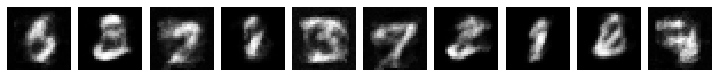

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
        axes[i].matshow(generated_data[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.8)

In [ ]:
from pyraug.augmentation import train_my_model

In [ ]:
train_my_model()

In [ ]:
model = train_my_model(data=dataset_to_augment, encoder=custom_enc, outputs/a)

Launching augmentation. Logs will be save in 'outputs'

No training_config provided. Using default.

No model_config provided. Using default.

No decoder architecture provided. Using default.

No metric architecture provided. Using default.

Created dummy_recording/training_2021-06-04_12-03-25
Creating dummy_recording/training_2021-06-04_12-03-25. Repo will be deleted at the end of training

RHVAE(
  (encoder): Encoder_Conv(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

dummy_recording/training_2021-06-04_12-03-25/encoder.pkl


In [ ]:
from pyraug.augmentation import augment_from_pretrained

In [ ]:
generated_data = augment_from_pretrained(
    model=model,
    number_of_samples=100
    )

No generation_config provided. Using default.

Launching generation !



Initializing to centroids
Initializing to centroids


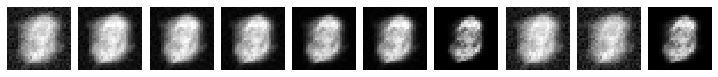

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
        axes[i].matshow(generated_data[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.8)

In [22]:
RHVAE.load_from_folder('../outputs/my_model_from_script/training_2021-06-22_17-07-54/final_model')

RHVAE(
  (encoder): Encoder_MLP_High(
    (layers): Sequential(
      (0): Linear(in_features=3072, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=500, bias=True)
      (3): ReLU()
      (4): Linear(in_features=500, out_features=400, bias=True)
    )
    (mu): Linear(in_features=400, out_features=10, bias=True)
    (std): Linear(in_features=400, out_features=10, bias=True)
  )
  (decoder): Decoder_MLP(
    (layers): Sequential(
      (0): Linear(in_features=10, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=3072, bias=True)
      (3): Sigmoid()
    )
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=3072, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=10, bias=True)
    (lower): Linear(in_features=400, out_features=45, bias=True)
  )
)

In [21]:
ls ../outputs/my_model_from_script/training_2021-06-22_17-07-54/

final_model/


In [24]:
torch.load('../outputs/my_generated_data_from_script/generation_2021-06-22_17-19-01/generated_data_10_0.pt').shape

torch.Size([10, 3072])

In [ ]:
model(dataset_to_augment.type(torch.float) /255.+0.0001)

(tensor([[0.0062, 0.0043, 0.0065,  ..., 0.0066, 0.0051, 0.0052],
         [0.0173, 0.0251, 0.0184,  ..., 0.0249, 0.0204, 0.0205],
         [0.0280, 0.0151, 0.0205,  ..., 0.0212, 0.0309, 0.0245],
         ...,
         [0.0062, 0.0119, 0.0058,  ..., 0.0128, 0.0063, 0.0066],
         [0.0301, 0.0265, 0.0225,  ..., 0.0370, 0.0208, 0.0271],
         [0.0206, 0.0126, 0.0156,  ..., 0.0165, 0.0245, 0.0168]],
        grad_fn=<SigmoidBackward>),
 tensor([[-1.1522, -0.1244, -2.1099,  ...,  2.2233, -0.6844,  2.2815],
         [ 0.1115,  0.2182, -1.9760,  ...,  0.9631,  0.7458,  1.0231],
         [-0.0588, -0.1437,  0.5366,  ...,  1.9954,  1.4945,  0.8236],
         ...,
         [ 0.9263, -1.6631, -1.9265,  ...,  0.1140,  0.0434, -0.7371],
         [-1.4952, -0.3787, -0.9741,  ...,  1.1608,  0.3417, -0.7760],
         [-0.4344, -1.0094,  2.6459,  ..., -0.8406, -0.2104,  2.4245]],
        grad_fn=<AddBackward0>),
 tensor([[-1.1458, -0.1371, -2.1004,  ...,  2.2251, -0.6747,  2.2803],
         [ 0.1

In [ ]:
model.model_con

False

In [ ]:
torch.tensor([[1, 2, ], [1, 9, 0]])

ValueError: expected sequence of length 2 at dim 1 (got 3)

In [ ]:
t = torch.tensor([1])

In [ ]:
issubclass(t.type, np.integer)

TypeError: issubclass() arg 1 must be a class

In [ ]:
from dataset import AutoDatasetsArguments

In [ ]:
auto = AutoDatasetsArguments(demo_dataset='mnist')

Loading mnist demo ...


/home/clement/Documents/these/implem/software/dataset.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data).type(torch.float)
/home/clement/Documents/these/implem/software/dataset.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets).type(torch.long)


In [ ]:
auto.data.shape, auto.targets

(torch.Size([500, 784]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
   

In [ ]:
from model import ModelArguments

In [ ]:
model = ModelArguments(latent_dim=3.)

TypeError: The field `latent_dim` was assigned by `<class 'float'>` instead of `<class 'int'>`

In [ ]:
help(ModelArguments)

Help on class ModelArguments in module model:

class ModelArguments(basetyping.TypingChecker)
 |  ModelArguments(latent_dim: int = 2) -> None
 |  
 |  ModelArguments(latent_dim: int = 2)
 |  
 |  Method resolution order:
 |      ModelArguments
 |      basetyping.TypingChecker
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |  
 |  __init__(self, latent_dim: int = 2) -> None
 |  
 |  __repr__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'latent_dim': <class 'int'>}
 |  
 |  __dataclass_fields__ = {'latent_dim': Field(name='latent_dim',type=<cl...
 |  
 |  __dataclass_params__ = _DataclassParams(init=True,repr=True,eq=True,or...
 |  
 |  __hash__ = None
 |  
 |  latent_dim = 2
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from basetyping.TypingChecker:
 |  
 |  __post_init__(self)
 |  

In [ ]:
m = ModelArguments(latent_dim=3)

Check is passed successfully


In [ ]:
m

ModelArguments(latent_dim=3)